# Notebook Lecture 10: Properties of Nonlinear Systems, LaSalle's Invariance Theorem, Nonlinear Control Strategies
@2025 ETH Zurich, Anna-Yaroslava Bodnar, Yunus Yazoglu, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

In [ ]:
!pip install numpy matplotlib scipy control ipywidgets plotly

In [ ]:
from scipy.integrate import solve_ivp
from scipy.fft import rfft, rfftfreq
import numpy as np
from scipy.signal import cont2discrete
import control
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider

from typing import Tuple, Sequence, List, Callable, Optional
import plotly
import plotly.graph_objects as go
from cycler import cycler

import matplotlib as mplbut
from ipywidgets import interact, FloatSlider
from matplotlib.lines import Line2D


# Part 1 - Properties of Nonlinear Systems

This part of the notebook will visually show you the properties of nonlinear systems discussed in the lecture.

## Superposition Principle

This notebook provides a hands-on demonstration of the superpositioin principle. We compare how a simple linear system and a nonlinear system respond to two individual inputs and to their sum, showing that:

1. **Linear system** obeys superposition (additivity + homogeneity).
2. **Nonlinear system** violates superposition once a quadratic state term is introduced.

By stepping through a custom simulation routine and plotting both systems under identical inputs, you'll see exactly how linearity guarantees that

$$y(u_1+u_2) = y(u_1)+y(u_2)$$

whereas even a small nonlinearity destroys that equality.

In [ ]:
def simulate(f, u, t_span, x0, t_eval):
    sol = solve_ivp(fun=lambda t, x: f(t, x, u(t)), t_span=t_span, y0=[x0], t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return t_eval, sol.y[0]

### System definitions

- **Input signals**
  - $u_1(t)$: unit-amplitude rectangular pulse
  - $u_2(t)$: sinusoid

- **Dynamical systems**
  1. **Linear**: $\dot{x}=-x+u(t)$
  2. **Nonlinear**: $\dot x = -x + \frac{1}{2}x^2 + u(t)$
  

In [ ]:
def u1(t):
    return 1.0 * ((t > 1) and (t < 6))

def u2(t):
    return 0.5 * np.sin(2 * np.pi * 0.5 * t) * (t < 10)

def u12(t):
    return u1(t) + u2(t)

In [ ]:
def f_linear(t: float, x: np.ndarray, u_val: float) -> np.ndarray:
    return -x + u_val

def f_nonlinear(t: float, x: np.ndarray, u_val: float) -> np.ndarray:
    return -x + 1/2*x**2 + u_val

In [ ]:
t_span = (1, 4)
t_eval = np.linspace(*t_span, 2000)

t,  y1_lin     = simulate(f_linear,    u1,   t_span, 0.0, t_eval)
_,  y2_lin     = simulate(f_linear,    u2,   t_span, 0.0, t_eval)
_,  y12_lin    = simulate(f_linear,    u12,  t_span, 0.0, t_eval)

_,  y1_non_lin = simulate(f_nonlinear, u1,   t_span, 0.0, t_eval)
_,  y2_non_lin = simulate(f_nonlinear, u2,   t_span, 0.0, t_eval)
_,  y12_non_lin= simulate(f_nonlinear, u12,  t_span, 0.0, t_eval)

In [ ]:
neon_cycle = cycler(color=[
    '#00FFF7',  # neon cyan
    '#FF00FF',  # neon magenta
    '#39FF14',  # neon green
    '#FF5F1F',  # neon orange
])

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

for a in ax:
    a.set_prop_cycle(neon_cycle)

ax[0].plot(t, y12_lin,              label='Response to u1 + u2')
ax[0].plot(t, y1_lin + y2_lin, '--', label='Sum of individual responses')
ax[0].set_title('Linear System: Superposition Holds')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(t, y12_non_lin,              label='Response to u1 + u2')
ax[1].plot(t, y1_non_lin + y2_non_lin, '--', label='Sum of individual responses')
ax[1].set_title('Nonlinear System: Superposition Violated')
ax[1].legend()
ax[1].grid(True)

ax[1].set_xlabel('Time [s]')

plt.tight_layout()
plt.show()

- **Linear system plot**:
  The solid curve (response to $u_1+u_2$) overlaps perfectly with the dashed curve ($y_1+y_2$)
- **Nonlinear system plot**:
  The solid curve and the dashed curve diverge, illustrating how the added $+\frac{1}{2}x^2$ term breaks additivity.

## Finite Escape Time

This notebook contrasts two fundamental growth behaviors:

- **Linear exponential growth** governed by $\dot x = x$, which grows without bound but only as $e^{t}$ and never "blows up" in finite time.
- **Nonlinear finite-time blow-up** governed by $\dot x = x^p$ for $p>1$, which admits an analytic escape time $t = \frac{1}{(p-1)x_0^{p-1}}$ at which the solution diverges to infinity.

By plotting both families of solutions for various initial states, you'll see how the nonlinear system truly "escapes" in finite time, whereas the linear system merely grows exponentially.

In [ ]:
def linear_solution(t: np.ndarray, x0: float, a: float = 1.0) -> np.ndarray:
    #x(t) for \dot{x} = a·x with initial state x0
    return x0 * np.exp(a * t)

def nonlinear_solution(t: np.ndarray, x0: float, p: float = 2.0) -> np.ndarray:
    #x(t) for \dot{x} = x^p  (p > 1)  with initial state x0.

    base = x0 ** (1 - p) - (p - 1) * t
    return base ** (-1.0 / (p - 1))

def blow_up_time(x0: float, p: float = 2.0) -> float:
    # Analytic finite escape time t = 1 / [(p–1) x0^(p-1)]
    if p <= 1:
        return np.inf
    return 1.0 / ((p - 1) * x0 ** (p - 1))

In [ ]:
def make_linear_trajectory(x0: float, t_max: float = 2.0, n_points: int = 1_000, a: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    t = np.linspace(0, t_max, n_points)
    x = linear_solution(t, x0, a)
    return t, x

def make_nonlinear_trajectory(x0: float, p: float = 2.0, safety: float = 0.99, n_points: int = 1_000) -> Tuple[np.ndarray, np.ndarray, float]:
    t_star = blow_up_time(x0, p)
    t = np.linspace(0, safety * t_star, n_points)
    x = nonlinear_solution(t, x0, p)
    return t, x, t_star

In [ ]:
def plot_linear_vs_nonlinear(linear_ics: Sequence[float] = (1.0,), nonlinear_ics: Sequence[float] = (1.0, 5.0), *, a: float = 1.0, p: float = 2.0, t_max_linear: float = 2.0, ylog: bool = True, figsize: Tuple[int, int] = (8, 6), colors: List[str] = None) -> None:
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.figure(figsize=figsize)

    # Plot linear family
    for k, x0 in enumerate(linear_ics):
        t, x = make_linear_trajectory(x0, t_max_linear, a=a)
        plt.plot(
            t,
            x,
            label=rf"Linear ẋ={a}x, $x_0={x0}$",
            color=colors[k % len(colors)],
            linewidth=1.8,
        )

    # Plot nonlinear family
    base_idx = len(linear_ics)
    for k, x0 in enumerate(nonlinear_ics):
        t, x, t_star = make_nonlinear_trajectory(x0, p=p)
        plt.plot(
            t,
            x,
            label=rf"Nonlinear ẋ=$x^{p:g}$, $x_0={x0}$",
            color=colors[(base_idx + k) % len(colors)],
            linewidth=1.8,
        )
        plt.axvline(
            t_star,
            linestyle="--",
            color=colors[(base_idx + k) % len(colors)],
            linewidth=0.8,
        )

    if ylog:
        plt.yscale("log")

    plt.xlabel("time $t$")
    plt.ylabel("$x(t)$")
    plt.title("Linear Exponential Growth vs Nonlinear Finite-Time Blow-Up")
    plt.legend()
    plt.grid(True, which="both", ls=":")
    plt.tight_layout()
    plt.show()

This notebook is designed to be modular: at the bottom you define two simple tuples,

In [ ]:
# Choose initial conditions:
linear_ics      =(1.0, )                # any number of x_0 values for the linear system
nonlinear_ics   =(0.5, 1.0, 2.0, 5.0)   # any number of x_0 values for the nonlinear system

Just replace these tuples with whatever initial states you like and re-run the final cell below.

In [ ]:
if __name__ == "__main__":
    plot_linear_vs_nonlinear(
        linear_ics    = linear_ics,
        nonlinear_ics = nonlinear_ics
    )

## Limit Cycles

This notebook visualizes how all trajectories of the Van der Pol oscillator

\begin{align*}
\dot x & = y \\
\dot y & = \mu \left(1-x^2\right) y + x
\end{align*}

with $\mu>0$ converge onto a stable limit cycle.

In [ ]:
# Van der Pol oscillator parameters
mu = 1
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

In [ ]:
initial_conditions = [[-5, 5], [-5, -5], [5, -5], [5, 5], [1,0], [-2, 4]]
labels = ['IC: (-5, 5)', 'IC: (-5, -5)', 'IC: (5, -5)', 'IC: (5, 5)', 'IC: (1, 0)', 'IC: (-2, 4)']

In [ ]:
# Van der Pol system
def van_der_pol(t: float, state: Sequence[float]) -> List[float]:
    x, y = state
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]

In [ ]:
# Plotting
fig = go.Figure()

for ic, label in zip(initial_conditions, labels):
    sol = solve_ivp(van_der_pol, t_span, ic, t_eval=t_eval, method='RK45')
    x, y = sol.y

    # Trajectory line
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=label))

    dx = y
    dy = mu * (1 - x**2) * y - x
    speed = np.sqrt(dx**2 + dy**2)
    dx_norm = dx / speed
    dy_norm = dy / speed

    step = 200
    arrow_len = 0.3
    for xi, yi, u, v in zip(x[::step], y[::step], dx_norm[::step], dy_norm[::step]):
        fig.add_annotation(
            x=xi + u * arrow_len, y=yi + v * arrow_len,
            ax=xi, ay=yi,
            xref='x', yref='y', axref='x', ayref='y',
            showarrow=True, arrowhead=2, arrowsize=1, opacity=1
        )

fig.update_layout(
    title='Van der Pol Phase Portrait',
    xaxis_title='x',
    yaxis_title='y',
    width=1000,
    height=600,
    legend_title_text='Initial Conditions'
)

fig.show()

## Sub-harmonic Osciallations


We saw for linear systems that if we chose a sinusoid input $u$ at frequency $\omega$, our output would also have the same frequency $\omega$ but shifted in time and scaled. This property does not hold for nonlinear system. For that we take a look at the forced duffing oscillator which is represented by:

$$
 \ddot{x} + \delta \dot{x} - \alpha x + \beta x^3 = \gamma cos(\omega t)
$$

Try to adjust the weights to:

Damping Coefficient: $\alpha = 0.2$

Linear Stiffness: $\beta = 0.3$

Nonlinear Stiffness: $\delta = 0.45$

Forcing Amplitude: $\gamma = 1.2$

Input Frequency: $f = 0.2$

and you will see that 2 additional frequencies that are multiples from our original frequency appear.

In [ ]:
def simulate_duffing(alpha=-1.0, beta=1.0, delta=0.3, gamma=0.5, omega=1.2):
    # Time settings
    T = 2 * np.pi / omega
    t_span = (0, 100)
    t_eval = np.linspace(t_span[0], t_span[1], 10000)

    # Initial conditions
    initial_conditions = [1.0, 0.0]

    # Duffing equation definition
    def duffing(t, y):
        x, v = y
        dxdt = v
        dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
        return [dxdt, dvdt]

    # Solve the ODE
    sol = solve_ivp(duffing, t_span, initial_conditions, t_eval=t_eval)
    t = sol.t
    x = sol.y[0]
    v = sol.y[1]

    # Frequency domain
    xf = rfftfreq(len(t), d=(t[1] - t[0]))
    yf = np.abs(rfft(x))

    # Poincaré section
    poincare_times = np.arange(0, t_span[1], T)
    poincare_x = np.interp(poincare_times, t, x)
    poincare_v = np.interp(poincare_times, t, v)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Time domain
    axs[0].plot(t, x)
    axs[0].set_title("Time Series")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("x(t)")

    # Frequency spectrum
    axs[1].plot(xf, yf)
    axs[1].set_title("Frequency Spectrum")
    axs[1].set_xlabel("Frequency")
    axs[1].set_ylabel("Amplitude")

    # Phase portrait
    axs[2].plot(x, v, linewidth=0.5)
    axs[2].scatter(poincare_x, poincare_v, color='red', s=10, label='Poincaré section')
    axs[2].set_title("Phase Portrait with Poincaré Section")
    axs[2].set_xlabel("x(t)")
    axs[2].set_ylabel("dx/dt")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Interactive sliders
sliders = {
    "alpha": FloatSlider(value=-1.0, min=-2.0, max=2.0, step=0.01, description='α'),
    "beta": FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.01, description='β'),
    "delta": FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, description='δ'),
    "gamma": FloatSlider(value=0.48, min=0.0, max=1.0, step=0.01, description='γ'),
    "omega": FloatSlider(value=1.2, min=0.5, max=2.0, step=0.01, description='ω'),
}

# Launch interactive widget
interact(simulate_duffing, **sliders)

# Part 2 - Lasalle's Invariance Principle

In this part of the notebook we illustrate LaSalle's invariance principle using a inverted pendulum with viscous damping. You'll see:
1. A Lyapunov candidate $V(\theta, \dot \theta)$ (total "energy" about the inverted equilibrium point).
2. How trajectories spiral in toward the largest invariant set within $\dot V=0$.

The inverted and damped pendulum dynamics can be written as

$$m\ell^2\ddot{\theta} = mg\ell \sin(\theta) - k_d\dot{\theta}$$

where $\theta$ represents the angle, by which the pendulum has been deviated from the **upright** position. E.g., as long as the pendulum does not start from the upright position with zero angular velocity, due to gravity, it will fall back to the downward position.  

In [ ]:
m: float  = 1.0    # [kg]
l: float  = 1.0    # [m]
g: float  = 9.81   # [m/s^2]
t_max     = 40.0
t_eval    = np.linspace(0, t_max, 600)

In [ ]:
def pendulum(t, y, kd):
  theta, theta_dot = y
  return [theta_dot, (g/ l) * np.sin(theta) - (kd / (m * l ** 2) * theta_dot)]

A valid, and suitable Lyapunov function is

$$V(\theta, \dot \theta) = \frac{1}{2} m \ell^2 \dot{\theta}^2 + mg\ell (1+\cos(\theta)).$$

This function is also known as the total energy of a system, since it is the kinetic energy plus the potential energy.

In [ ]:
def V(theta, theta_dot):
  return 0.5 * m * l ** 2 * theta_dot ** 2 + m * g * l * (1 + np.cos(theta))

### Lyapunov Direct Method

To apply **Lyapunov’s direct method** we need a function whose value decreases
along every trajectory.  
Starting from the total-energy candidate  


$$V(\theta,\dot\theta)=\tfrac12 m\ell^{2}\dot\theta^{2}+mg\ell\bigl(1+\cos\theta\bigr)$$

its time-derivative is


\begin{aligned}
\dot V(\theta,\dot\theta)
&=\frac{\partial V}{\partial\theta}\,\dot\theta+\frac{\partial V}{\partial\dot\theta}\,\ddot\theta \\
&=mg\ell\sin\theta\,\dot\theta
        -m\ell^{2}\dot\theta\!\left(\frac{g}{\ell}\sin\theta-\frac{k_{d}}{m\ell^{2}}\dot\theta\right)\\
&=mg\ell\sin\theta\,\dot\theta-mg\ell\sin\theta\,\dot\theta
      -\frac{k_{d}}{m\ell^{2}}\dot\theta^{2} \\[2pt]
&=-\frac{k_{d}}{m\ell^{2}}\dot\theta^{2}\;\le\;0.
\end{aligned}

### LaSalle's Invariance Principle

Because $\dot V$ is **negative semi-definite**—it vanishes whenever
$\dot\theta=0$ —Lyapunov’s theorem guarantees **stability** but not yet
**asymptotic** stability.

Using LaSalle’s invariance principle

LaSalle states that every trajectory starting in  
$$\Omega=\{(\theta,\dot\theta)\mid V(\theta,\dot\theta)\le V(\theta_0,\dot\theta_0)\}$$

will converge to the **largest invariant set** contained in
$\dot V=0$.

For the damped pendulum $\dot V=0 \;\Longrightarrow\; \dot\theta=0$ so the only trajectories that can remain in $\dot V=0$ for all time are
the **equilibria** $(\theta,\dot\theta)=(\pi,0)\ \text{and}\ (\theta,\dot\theta)=(-\pi,0)$ (same point on the circle).

This set $M=\{(\pm\pi,0)\}$ is invariant, and by LaSalle every solution that starts in $\Omega$ converges to M. Hence the downward equilibrium is **asymptotically stable**.


In [ ]:
ics_deg = [(25, 0), (-20, 2), (10, -3)]
colors   = ["tab:blue", "tab:orange", "tab:green"]

In [ ]:
def demo(kd = 0.5):

  # Ignore this.
  #---------------------------------------------------
  get_ipython().run_cell(
        "m = 1.0    # [kg]\n"
        "l = 1.0    # [m]\n"
        "g = 9.81   # [m/s**2]\n"
        "t_max = 40.0\n"
        "t_eval = np.linspace(0, t_max, 600)\n"
  )
  plt.close('all')
  #---------------------------------------------------

  # simulate trajectories
  trajs = []
  dyn = lambda t, y: pendulum(t, y, kd)

  for (theta, theta_dot), col in zip(ics_deg, colors):
    sol = solve_ivp(
        dyn, [0, t_max],
        (np.deg2rad(theta), theta_dot),
        t_eval = t_eval,
        rtol = 1e-9,
        atol = 1e-12
    )
    trajs.append((sol, col))


  all_theta = np.hstack([sol.y[0] for sol, _ in trajs])
  all_theta_dot = np.hstack([sol.y[1] for sol, _ in trajs])
  theta_min, theta_max = all_theta.min(), all_theta.max()
  theta_dot_min, theta_dot_max = all_theta_dot.min(), all_theta_dot.max()
  pad_theta = 0.1*(theta_max - theta_min if theta_max > theta_min else np.pi / 4)
  pad_theta_dot = 0.1 * (theta_dot_max - theta_dot_min if theta_dot_max > theta_dot_min else 1.0)
  initial_theta_dot = [theta_dot_0 for (_, theta_dot_0) in ics_deg]
  theta_dot_lo = min(theta_dot_min - pad_theta_dot, min(initial_theta_dot) - pad_theta_dot)
  theta_dot_hi = max(theta_dot_max + pad_theta_dot, max(initial_theta_dot) + pad_theta_dot)
  theta_lo = theta_min - pad_theta
  theta_hi = theta_max + pad_theta

  # background V-grid
  theta_grid = np.linspace(theta_lo, theta_hi, 400)
  theta_dot_grid = np.linspace(theta_dot_lo, theta_dot_hi, 400)
  theta_, theta_dot_ = np.meshgrid(theta_grid, theta_dot_grid)
  V_grid = V(theta_, theta_dot_)

  fig, (ax_p, ax_e) = plt.subplots(1, 2, figsize=(12, 5))

  ax_p.contour(theta_, theta_dot_, V_grid, levels=np.linspace(V_grid.min(), V_grid.max(), 12), linestyles=':', colors='grey')

  # Omega : \dot{V} \leq 0 label
  #ax_p.text(theta_lo + 0.02 * (theta_hi - theta_lo), 0.90 * (theta_dot_hi - theta_dot_lo) + theta_dot_lo, r'$\Omega: \dot{V}\leq 0$', color='navy', fontsize=16, fontweight='bold')
  ax_p.text(
    theta_lo + 0.02*(theta_hi - theta_lo),
    0.90*(theta_dot_hi - theta_dot_lo) + theta_dot_lo,
    r'$\Omega :\; \dot{V}\leq 0$',
    color='navy',
    fontsize=16,
    fontweight='bold',
    bbox=dict(
        facecolor='white',
        edgecolor='none',
        pad=4
    )
  )

  # E set
  ax_p.plot([theta_lo, theta_hi], [0, 0], ls = '--', lw=2, color='magenta', label=r'$E:\dot{V}=0$')

  for (sol, col), (theta_0, _) in zip(trajs, ics_deg):
    ax_p.plot(sol.y[0], sol.y[1], color=col, label=f'θ₀={theta_0}°')
    ax_p.plot(sol.y[0][0], sol.y[1][0], 'o', color=col, mfc='none')
    ax_e.plot(sol.t, V(sol.y[0], sol.y[1]), color=col, label=f'V, θ₀={theta_0}°')

  for k in [-1, 1]:
    ax_p.plot(k * np.pi, 0, 'co', ms=10, mfc='none', mec='red', mew=2)

  red_circle = Line2D([0], [0], marker='o', linestyle='None',
                        markeredgecolor='red', markerfacecolor='none',
                        markersize=10, label=r'$M$')
  handles, labels = ax_p.get_legend_handles_labels()
  handles.append(red_circle)
  labels.append(r'$M=LIS$')
  ax_p.legend(handles, labels, fontsize=9, loc='upper right')

  ax_e.set_xlabel('time (s)'); ax_e.set_ylabel('V')
  ax_e.set_title('Lyapunov function over time')
  ax_e.legend(fontsize=9)

  plt.tight_layout()
  plt.show()

Run the cell below and afterwards move the $k_d$ slider to change the viscous-damping coefficient.

In [ ]:
interact(
    demo,
    kd=FloatSlider(value=0.5, min=0.5, max=2.0, step=0.05, description='$k_d$')
)

# Part 3 - Nonlinear Control Strategies

In this part of the notebook, we are going to try to control a quadcopter such that it tracks a specific reference. In this example, we are going to see that linearizing the system only at one equilibrium point will fail and therefore we need to schedule between different equilibrium points and their linearizations.



## Gain Scheduling for a Quadrotor

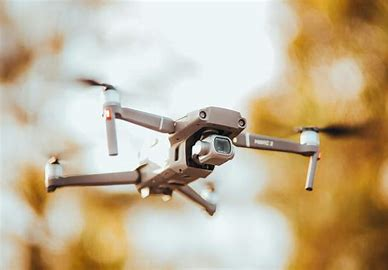

The first step before designing a controller for a quadcopter is to understand its dynamics. Quadcopters are popular due to their good manuverability. They have 6 degrees of freedom: movement in x, y and z direction as well as rotation around the pitch angle ($\theta$ ), roll angle ($\phi$) and yaw anlge ($\psi$). These movements are controlled by independently changing the speeds of its four rotors. We have four control inputs: thrust, pitch, roll and yaw input moment that are related to the different combination of forces $F_i$.  




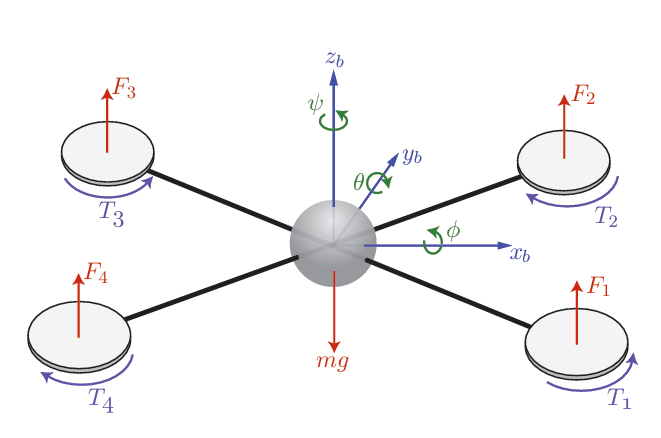

A detailed derivation of the dynamics can be found in "Gain-Scheduled Control of a Quadcopter UAV" (Link: https://dspacemainprd01.lib.uwaterloo.ca/server/api/core/bitstreams/ce71b36a-eebf-45fa-88e8-03a01a0d0f6f/content).

We will now focus on the resulting state space form. In the case of the quadcopter, we have a 12 dimensional state vector:

$$
  \textbf{x} = \begin{bmatrix} x & y & z & \theta & \phi &  \psi & \dot{x} & \dot{y} & \dot{z} & \dot{\theta} & \dot{\phi} & \dot{\psi} \end{bmatrix} ^T
$$

And we have a four dimensional output:

$$
  \textbf{y} = \begin{bmatrix} x & y & z & \psi \end{bmatrix}
$$


Compared to linear systems, a nonlinear system has multiple equilibria. We can find the equilibrium points, if we solve the following equation:

$$
 \dot{x} = 0 = f(x_{eq}, u_{eq})
$$

That would result in the steady state hovering position of the quadcopter:

$$
  \textbf{x}_{eq} = \begin{bmatrix} x_{ss} & y_{ss} & z_{ss} & 0 & 0 &  \psi_{ss} & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} ^T
$$

$$
  \textbf{u}_{eq} = \begin{bmatrix} g & 0 & 0 & 0 \end{bmatrix}
$$

We can linearize the nonlinear dynamics equations at each equilibrium point and get the following linear system dynamics:


$$
 \textbf{x} = A (\psi_{ss}) \cdot ( x - x_{eq}) + B \cdot ( u - u_{eq})
$$

$$
 \textbf{y} = C \cdot ( y - y_{eq})
$$

We can use the Jacobian Linearization at each equilibrium point and that would result in the following state space realization.



$$
  A = \begin{bmatrix} \textbf{0}_{6x6} & \textbf{I}_{6} \cr 𝚿(\psi_{ss}) & 𝚫 \end{bmatrix}
$$

 

$$
  B = \begin{bmatrix} \textbf{0}_{8x4} \cr \textbf{I}_{4}  \end{bmatrix}
$$



$$
 C = \begin{bmatrix} 1 & 0 & 0 & 0  &
    0& 0 & 0 & 0 & 0 & 0 &
    0 & 0 \cr 0 & 1 & 0 & 0  &
    0& 0 & 0 & 0 & 0 & 0 &
    0 & 0  \cr 0 & 0 & 1 & 0  &
    0& 0 & 0 & 0 & 0 & 0 &
    0 & 0 \cr 0 & 0 & 0 & 0  &
    0 & 1 & 0 & 0 & 0 & 0 &
    0 & 0  \end{bmatrix}
$$



$$
 D = \begin{bmatrix} \textbf{0}_{4x4} \end{bmatrix}
$$

With

$$
   𝚿(\psi_{ss}) = \begin{bmatrix} 0 & 0 & 0 & g \cdot cos(\psi_{ss})   &
    g \cdot sin(\psi_{ss}) & 0 \cr 0 & 0 & 0 & g \cdot sin(\psi_{ss})   &
    -g \cdot cos(\psi_{ss}) & 0 \cr 0 & 0 & 0 & 0 &
    0 & 0 \cr 0 & 0 & 0 & 0 &
    0 & 0 \cr 0 & 0 & 0 & 0 &
    0 & 0 \cr 0 & 0 & 0 & 0 &
    0 & 0 \end{bmatrix}
$$

And

$$
 𝚫 = \begin{bmatrix} -k_1/m & 0 & 0 & 0  &
    0& 0 \cr 0 & -k_2/m & 0 & 0 &
    0 & 0 \cr 0 & 0 & -k_3/m & 0 &
    0 & 0 \cr 0 & 0 & 0 & -k_4 l/I_1 &
    0 & 0 \cr 0 & 0 & 0 & 0 &
    -k_5 l/I_2 & 0 \cr 0 & 0 & 0 & 0 &
    0 & -k_6/I_3 \end{bmatrix}
$$


We note that the A matrix depends on the yaw angle. That means that we are dealing here with a linear parameter-varying system, as our linearized form depends on an exogenous parameter (here $\psi_{ss}$).
So the A matrix will change in during the movement of the quadcopter.

Now we would like to show the reason why gain scheduling is actually needed. Imagine you are linearizing your system at only one equilibrium point (in this case we choose $\psi$ = 0). As we are going to operate in discrete time, we have to discretize our system. We would construct a LQR controller and calculate our controller gain K with the discrete Ricatti equation.

In [ ]:
#simulation parameter
g = 9.8
m = 2              # mass
l = 0.2            # half of the adjacent rotor distance
I1 = 1.25          # Moment of Inertia
I2 = 1.25          # Moment of Inertia
I3 = 2.5           # Moment of Inertia
k1 = 0.01          # Drag coefficient
k2 = 0.01          # Drag coefficient
k3 = 0.01          # Drag coefficient
k4 = 0.012         # Drag coefficient
k5 = 0.012         # Drag coefficient
k6 = 0.012         # Drag coefficient

#discretized state-space form
def state_space(psi, Ts):
  big_psi = np.block([[np.zeros((2,3)), np.array([[g*np.cos(psi), g*np.sin(psi), 0], [g*np.sin(psi), -g*np.cos(psi), 0]])],
                    [np.zeros((4,3)), np.zeros((4,3))]])

  A = np.block([[np.zeros((6,6)), np.identity(6)],
              [big_psi, np.diag((-k1/m, -k2/m, -k3/m, -k4*l/I1, -k5*l/I2, -k6/I3))]])
  B = np.block([[np.zeros((8,4))],
                [np.identity(4)]])

  C = np.block([[np.identity(3), np.zeros((3,9))],
                [np.zeros((1,5)), 1, np.zeros((1,6))]])

  D = np.zeros((4,4))

  sys_d = cont2discrete((A, B, C, D), Ts, method='zoh')

  A_d, B_d, C_d, D_d, dt = sys_d

  return A_d, B_d, C_d, D_d

#Adjust weight for Q and R (you can play with the variables if you like)
wx1 = 100000
wy1 = 100000
wz1 = 1
w_psi1 = 100000

Q = np.diag([wx1, wy1, wz1, 1,1,w_psi1, 1, 1, 1, 1, 1, 1])
R = np.diag([0.01, 0.01, 0.01, 0.01])

def get_K(psi, Ts):
  A_d, B_d, C_d, D_d = state_space(psi, Ts)
  _,_,K = control.dare(A_d, B_d, Q, R)
  return K, A_d, B_d, C_d, D_d


Next we choose a reference trajectory that we would like to follow. This case we chose a circle with radius 10. We have selected two reference trajectories:

1. We move along the circle and do not change the yaw angle (so the drone does not rotate alng the z-axis during movement). Our $\psi$ = 0 for all times.

2. We move along the circle and we would like to have the drone nose pointing along the tangent of the curve. In this case our $\psi$ is the angle of the tangent at the specific point.

In [ ]:
k = np.linspace(0, 2*np.pi, 1000)
Ts = np.pi/len(k)
rad = 10
x_ref = rad*np.sin(k)
y_ref = -rad*np.cos(k)
z_ref = [0 for i in k]
psi_ref_2 = np.arctan2(np.sin(k), np.cos(k))  # tangent to circular path
psi_ref_1 = [0 for i in k]                    # always zero
r_1 = np.column_stack((x_ref, y_ref, z_ref, psi_ref_1))
r_2 = np.column_stack((x_ref, y_ref, z_ref, psi_ref_2))

Now we are going to see the difference between these two references:

In [ ]:
#choose fraction of trajectory to calculate the behaviour
frac = 0.35
end = int(len(k)*frac)
k_frac = k[:end]


#initial conditions
x_1 = np.zeros((len(k_frac), 12))
y_1 = np.zeros((len(k_frac), 4))

x_2 = np.zeros((len(k_frac), 12))
y_2 = np.zeros((len(k_frac), 4))

#we start hovering in the bottom lowest part
x_init = np.transpose([0, -rad, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
u_ss = np.transpose([g,0,0,0])

x_1[0] = x_init
x_2[0] = x_init

#linearize the system at psi = 0 and design the LQR controller
K, A_d, B_d, C_d, D_d = get_K(0, Ts)

#first reference
for i in range(len(k_frac)):
    y_1[i] = C_d @ x_1[i]

    #we need to update the new A matrix as it depends on the current psi
    A_d_new, _, _, _ = state_space(y_1[i][3], Ts)
    u = - K @ (x_1[i] - C_d.T @ r_1[i]) + u_ss

    if i < len(k_frac) - 1:
        x_1[i+1] = A_d_new @ x_1[i] + B_d @ u

#second reference
for i in range(len(k_frac)):
    y_2[i] = C_d @ x_2[i]

    #we need to update the new A matrix as it depends on the current psi
    A_d_new, _, _, _ = state_space(y_2[i][3], Ts)
    u = - K @ (x_2[i] - C_d.T @ r_2[i]) + u_ss

    if i < len(k_frac) - 1:
        x_2[i+1] = A_d_new @ x_2[i] + B_d @ u


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title('Reference with psi=0')
axs[1].set_title('Reference with psi changing')
axs[0].plot(r_1[:,0], r_1[:,1], 'b--', label='Reference')
axs[1].plot(r_1[:,0], r_1[:,1], 'b--', label='Reference')
axs[0].plot(y_1[:,0], y_1[:,1], 'g-', label='Tracked Output')
axs[1].plot(y_2[:,0], y_2[:,1], 'r-', label='Tracked Output')
axs[0].set_xlabel('x(t)')
axs[0].set_ylabel('y(t)')
axs[1].set_xlabel('x(t)')
axs[1].set_ylabel('y(t)')
axs[0].axis('equal')
axs[1].axis('equal')
axs[0].legend()
axs[1].legend()

plt.show()

You see in the left graph, that we track the reference perfectly. The reason for that is that we have a constant reference for our psi, so our system is forced to fulfill that. In that case we do not deviate from our equilibrium point.

The right graph shows you that as our reference forces us to deviate from our equilibrium point at $\psi$ = 0 and turn the quadcopter at its yaw angle, our system looses track. Our controller that we specifically designed for our one equilibrium point does not ensure reference tracking.

How do we deal with that and how can we design a new controller so that we can still track this reference?

We apply the Gain Scheduling method. This works as follows:

1. We start our movement and take the current $\psi$ to calculate the A matrix. With this we can calculate the LQR controll gain K and we save our $\psi_{LQR}$.

2. We then choose a tolerance $\psi_{tol}$. If our value of $\psi$ during our movement deviates by more than that amount from our $\psi_{LQR}$ than we design a new LQR control gain based on the current A($\psi$). So in that case we switch between different controllers that are designed at different equilibrium points. Our control input would therefore be

$$
  u = - K(\psi_{LQR}^*) \cdot (x - S \cdot r(t)) + u_{ss}
$$

Now we have a many different controllers and we have to schedule them. That means that every time step we check what the current $\psi$ is and decide which of the K values that we calculated with our Ricatti equations before we would like to choose.

The Block Diagram looks as follows:

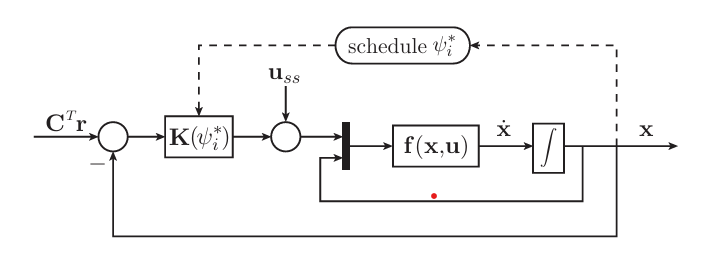

Let us use the reference 2 from before. If you like, you can also change the reference trajectory as you wish and see how the system behaves.

In [ ]:
k = np.linspace(0, 2*np.pi, 1000)
rad = 10
x_ref = rad*np.sin(k)
y_ref = -rad*np.cos(k)
z_ref = [0 for i in k]
psi_ref = np.arctan2(np.sin(k), np.cos(k))
r = np.column_stack((x_ref, y_ref, z_ref, psi_ref))


x = np.zeros((len(k), 12))
y = np.zeros((len(k), 4))
x_init = np.transpose([0, -rad, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
u_ss = np.transpose([g,0,0,0])
x[0] = x_init

You can adjust the $\psi_{tol}$ as you wish and see what happens. The different colors in the plot indicate that the system switched the controller.

In [ ]:
wx1 = 100000
wy1 = 100000
wz1 = 1
w_psi1 = 100000
Q = np.diag([wx1, wy1, wz1, 1, 1, w_psi1, 1, 1, 1, 1, 1, 1])
R = np.diag([0.01, 0.01, 0.01, 0.01])

def get_K_and_states(psi, Ts):
  A_d, B_d, C_d, D_d = state_space(psi, Ts)
  _,_,K = control.dare(A_d, B_d, Q, R)
  return K, A_d, B_d, C_d, D_d

def plot_with_psi_tol(psi_tol):
  rad = 10
  psi_curr = 0
  x_ref = rad*np.sin(k)
  y_ref = -rad*np.cos(k)
  z_ref = [0 for i in k]
  psi_ref = np.arctan2(np.sin(k), np.cos(k))
  r = np.column_stack((x_ref, y_ref, z_ref, psi_ref))

  x = np.zeros((len(k), 12))
  y = np.zeros((len(k), 4))
  x_init = np.transpose([0, -rad, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  u_ss = np.transpose([g,0,0,0])
  x[0] = x_init

  K, A_d, B_d, C_d, D_d = get_K_and_states(0, Ts)

  switched_index = [0]
  distinct_colors = [
      'red', 'blue', 'green', 'orange', 'purple', 'brown',
      'pink', 'gray', 'olive', 'cyan', 'magenta', 'black'
  ]

  # Fallback in case there are more switches than colors
  def get_color(idx):
      return distinct_colors[idx % len(distinct_colors)]

  for i in range(0, len(k)):
    y[i] = C_d @ x[i]
    A_d_new, _, _, _ = state_space(y[i][3], Ts)

    if abs(y[i][3] - psi_curr) > psi_tol:
      psi_curr = y[i][3]
      K, A_d, B_d, C_d, D_d = get_K_and_states(psi_curr, Ts)
      switched_index.append(i)

    u = - K @ (x[i] - np.transpose(C_d) @ r[i]) + u_ss

    if i < len(k)-1:
      x[i+1] = A_d_new @ x[i] + B_d @ u

  switched_index.append(len(k)-1)
  num_segments = len(switched_index)-1

  plt.figure(figsize=(8, 6))
  plt.plot(r[:, 0], r[:, 1], 'k--', label='Reference')
  for idx in range(num_segments):
      color = get_color(idx)
      start = switched_index[idx]
      end = switched_index[idx + 1]
      plt.plot(y[start:end, 0], y[start:end, 1], color=color, linewidth=2, label=f'Segment {idx+1}')

  plt.axis('equal')
  plt.show()


interact(
     plot_with_psi_tol,
     psi_tol=FloatSlider(value=np.pi/4, min=np.pi/12, max=np.pi*5/12, step=np.pi/40, description='psi_tol')
 )

You can see that the tighter the tolerance, the more often the controller switches and the better the reference trajectory tracking is as we work with more equilibrium point.

## Backstepping Applied to an Indoor Micro Quadrotor

In this section of the notebook we implement teh **back-stepping controller** proposed by Bouabdallah & Siegwart (2005) for the rotational subsystem of a quadrotor.

**Quadrotor Dynamics — from Newton–Euler to the 6-DOF model**  

A quadrotor is a **rigid body** acted upon by four propellers that supply both lift and control torques.  
Starting from the Newton–Euler equations for a body–fixed frame and an inertial frame

$$\begin{bmatrix}
m\mathbf I_{3\times3} & \mathbf0\\[2pt]
\mathbf0 & \mathbf I\!
\end{bmatrix}
\begin{bmatrix}
\dot{\mathbf V}\\[2pt]
\dot{\boldsymbol\omega}
\end{bmatrix}
+
\begin{bmatrix}
\boldsymbol\omega \!\times\! m\mathbf V\\[2pt]
\boldsymbol\omega \!\times\! \mathbf I\boldsymbol\omega
\end{bmatrix}
=
\begin{bmatrix}
\mathbf F\\[2pt]
\boldsymbol\tau
\end{bmatrix},
\tag{1}
$$

the authors of Bouabdallah & Siegwart (2005) derive an **approximate 6-DOF model** (their Eq. 6) expressed in Euler angles $(\varphi, \theta, \psi)$:


\begin{aligned}
\ddot φ &= \frac{I_y - I_z}{I_x}\, \dot θ \dot ψ - \frac{J_r}{I_x}\, \dot θ Ω + \frac{l}{I_x} U_2,\\[4pt]
\ddot θ &= \frac{I_z - I_x}{I_y}\, \dot φ \dot ψ + \frac{J_r}{I_y}\, \dot φ Ω + \frac{l}{I_y} U_3,\\[4pt]
\ddot ψ &= \frac{I_x - I_y}{I_z}\, \dot φ \dot θ + \frac{1}{I_z} U_4,\\[4pt]
\ddot z &= -g + \frac{\cos φ \cos θ}{m} U_1,\\[4pt]
\ddot x &= \frac{\cos φ \sin θ \cos ψ + \sin φ \sin ψ}{m} U_1,\\[4pt]
\ddot y &= \frac{\cos φ \sin θ \sin ψ - \sin φ \cos ψ}{m} U_1.
\end{aligned}

This model can be rewritten in a state space form $\dot{x}=f(x,u)$ with $x=(x_1, \dots, x_2)\in \mathbb{R}^{12}$. $x$ represents the state of the system, e.g.,

$$x=
\begin{pmatrix}
\phi & \dot{\phi} & \theta & \dot{\theta} & \psi & \dot \psi & z & \dot z & x & \dot x & y & \dot y
\end{pmatrix}^T.$$

The nonlinear function $f(x,u)$ is defined as

$$f(x,u)=
\begin{pmatrix}
x_2 \\
x_4x_6a_1 + x_4 a_2 \Omega + b_1 u_2 \\
x_4 \\
x_2x_6a_3 + x_2 a_4 \Omega + b_2 u_3 \\
x_6 \\
x_4x_2a_5 + b_3 u_4 \\
x_8-g + (\cos x_2 \cos x_3) \frac{1}{m} u_1\\
x_10\\
u_x \frac{1}{m} u_1\\
x_{12}\\
u_y \frac{1}{m}u_1
\end{pmatrix}.$$




In [ ]:
# Quadrotor rotational dynamics parameters
Ix = 0.02
Iy = 0.017
Iz = 0.03
l = 0.1
Jr = 1e-4

# Model coefficients
a1 = (Iy - Iz)/Ix
a2 = -Jr/Ix
a3 = (Iz - Ix)/Iy
a4 = Jr/Iy
a5 = (Ix - Iy)/Iz

b1 = l/Ix
b2 = l/Iy
b3 = l/Iz

In [ ]:
alpha1 = 2.0
alpha2 = 1.5
alpha3 = 2.0
alpha4 = 1.5
alpha5 = 1.0
alpha6 = 1.0

Omega  = 0.0

# desired angles
phi_d   = 0.0
theta_d = 0.0
psi_d   = 0.0

phi_dot_d   = 0.0
theta_dot_d = 0.0
psi_dot_d   = 0.0

**Backstepping Control of the Rotations Subsystem**

Below we implement the three torque inputs

\begin{align*}
u_1 & = \frac{1}{b_1} (z_1-a_1x_4x_6-a_2x_4\Omega -\alpha_1 (z_2+\alpha _1z_1)-\alpha_2 z_2)\\
u_3 & = \frac{1}{b_2}\left(z_3 -a_3 x_2x_6 -a_4 x_2 \Omega - \alpha_3 (z_4 + \alpha_3 z_3) - \alpha_4 z_4\right)\\
u_4 & = \frac{1}{b_3}(z_5 - a_5 x_2 x_4 -\alpha_5 (z_6+\alpha_5z_5) -\alpha_6 z_6)
\end{align*}

via the back-stepping laws derived in Bouabdallah & Siegwart (2005). In code you’ll see the exact formulas for the parameters.

**For the full derivation**, including Lyapunov analysis and the two-step virtual control, please refer to Section V-A of the original paper.


In [ ]:
# Backstepping controller of rotations subsystem

def backstepping(t, state):
    phi, phidot, theta, thetadot, psi, psidot = state

    # Error variables
    z1 = phi_d - phi
    z2 = phidot - phi_dot_d - alpha1*z1
    z3 = theta_d - theta
    z4 = thetadot - theta_dot_d - alpha3*z3
    z5 = psi_d - psi
    z6 = psidot - psi_dot_d - alpha5*z5

    # Virtual controllers

    u2 = (1/b1)*(z3 - a3*thetadot*psidot - a2*thetadot*Omega - alpha1*(z2 + alpha1*z1) - alpha2*z2)
    u3 = (1/b2)*(z1 - a3*phidot*psidot   - a4*phidot*Omega   - alpha3*(z4 + alpha3*z3) - alpha4*z4)
    u4 = (1/b3)*(z5 - a5*phidot*thetadot                     - alpha5*(z6 + alpha5*z5) - alpha6*z6)

    # Dynamics
    phi_ddot     = thetadot*psidot*a1   - Jr/Ix*theta_d*Omega + l/Ix*u2
    theta_ddot   = phidot*psidot*a3     + Jr/Iy*phi_d*Omega   + l/Iy*u3
    psi_ddot     = phidot*thetadot*a5   + 1/Iz*u4

    return [phidot, phi_ddot, thetadot, theta_ddot, psidot, psi_ddot]

In [ ]:
# Simulation

def rotaional_demo(phi0, phidot0, theta0, thetadot0, psi0, psidot0) -> None:
    initial_state = [phi0, phidot0, theta0, thetadot0, psi0, psidot0]
    t_final= 10.0
    t_eval = np.linspace(0, t_final, int(100*t_final)+1)

    sol = solve_ivp(backstepping, (0, t_final), initial_state, t_eval=t_eval, rtol=1e-6, atol=1e-8)

    #plt.figure(figsize=(8,4))
    plt.figure(figsize=(8,4), dpi=150)

    plt.plot(sol.t, sol.y[0], label='φ (roll)')
    plt.plot(sol.t, sol.y[2], label='θ (pitch)')
    plt.plot(sol.t, sol.y[4], label='ψ (yaw)')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle [rad]')
    plt.title('Rotational Backstepping Control')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Below you can **interactively adjust** the starting angles via the sliders and immediately see how the system responds under our back-stepping laws.

In [ ]:
# DON'T TOUCH THIS!
interact(
    rotaional_demo,
    phi0=FloatSlider(min=-1.5, max=1.5, step=0.1, value=0.7, description='φ₀'),
    phidot0=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='φ̇₀'),
    theta0=FloatSlider(min=-1.5, max=1.5, step=0.1, value=0.5, description='θ₀'),
    thetadot0=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='θ̇₀'),
    psi0=FloatSlider(min=-1.5, max=1.5, step=0.1, value=0.3, description='ψ₀'),
    psidot0=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='ψ̇₀'),
)

These behaviors mirror Fig. 10 in Bouabdallah & Siegwart (2005), confirming that the back-stepping controller **robustly stabilizes** all three angles despite nonlinear gyroscopic coupling.